In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import os

# Define parameters
img_height, img_width = 150, 150
batch_size = 16
epochs = 50
dataset_path = 'dataset'  # Updated to reflect the new dataset directory
model_path = 'model/cnn_model.pth'

# Define the transformations
transform = transforms.Compose([
    transforms.Resize((img_height, img_width)),
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(degrees=0, translate=(0.2, 0.2)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Standard normalization
])

# Prepare the dataset
train_dataset = datasets.ImageFolder(root=dataset_path, transform=transform)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

# Check dataset
print(f"Classes: {train_dataset.class_to_idx}")
print(f"Number of samples: {len(train_dataset)}")
print(f"Batch size: {batch_size}")

# Build the CNN model
class CNNModel(nn.Module):
    def __init__(self, num_classes):
        super(CNNModel, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * (img_height // 8) * (img_width // 8), 512),
            nn.ReLU(),
            nn.Linear(512, num_classes)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

num_classes = len(train_dataset.classes)
model = CNNModel(num_classes)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

# Train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100 * correct / total
    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")

# Save the model
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")


Classes: {'chiikawa': 0, 'hachiware': 1, 'usagi': 2}
Number of samples: 46
Batch size: 16
Epoch 1/50, Loss: 3.2091, Accuracy: 34.78%
Epoch 2/50, Loss: 1.6258, Accuracy: 32.61%
Epoch 3/50, Loss: 1.1212, Accuracy: 30.43%
Epoch 4/50, Loss: 1.0900, Accuracy: 32.61%
Epoch 5/50, Loss: 1.0778, Accuracy: 39.13%
Epoch 6/50, Loss: 1.0838, Accuracy: 41.30%
Epoch 7/50, Loss: 1.0442, Accuracy: 39.13%
Epoch 8/50, Loss: 1.0323, Accuracy: 47.83%
Epoch 9/50, Loss: 0.9303, Accuracy: 63.04%
Epoch 10/50, Loss: 0.8419, Accuracy: 58.70%
Epoch 11/50, Loss: 0.8427, Accuracy: 60.87%
Epoch 12/50, Loss: 0.7754, Accuracy: 67.39%
Epoch 13/50, Loss: 1.0329, Accuracy: 60.87%
Epoch 14/50, Loss: 1.0008, Accuracy: 45.65%
Epoch 15/50, Loss: 0.8094, Accuracy: 58.70%
Epoch 16/50, Loss: 0.7262, Accuracy: 76.09%
Epoch 17/50, Loss: 0.6581, Accuracy: 80.43%
Epoch 18/50, Loss: 0.5772, Accuracy: 82.61%
Epoch 19/50, Loss: 0.6170, Accuracy: 73.91%
Epoch 20/50, Loss: 0.4640, Accuracy: 84.78%
Epoch 21/50, Loss: 0.5339, Accuracy: 84

/var/folders/8f/s_44b7ls3h596l8n0ck4wc3h0000gn/T/ipykernel_26614/200684378.py:44: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))

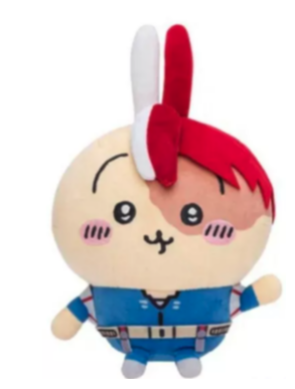

Image: /Users/chutszkan/Desktop/Github/ImageProcessing-note/CNNs/test_images/test5.jpg
Class probabilities:
  chikawa: 0.0010
  hachiwai: 0.7439
  usagi: 0.2550
Predicted class: hachiwai


In [13]:
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn.functional as F

def predict_result(test_image_path):
    # Define parameters
    img_height, img_width = 150, 150
    model_path = 'model/cnn_model.pth'  # Path to the trained model

    # Define the CNN model
    class CNNModel(nn.Module):
        def __init__(self, num_classes):
            super(CNNModel, self).__init__()
            self.features = nn.Sequential(
                nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2, stride=2)
            )
            self.classifier = nn.Sequential(
                nn.Flatten(),
                nn.Linear(128 * (img_height // 8) * (img_width // 8), 512),
                nn.ReLU(),
                nn.Linear(512, num_classes)
            )
        
        def forward(self, x):
            x = self.features(x)
            x = self.classifier(x)
            return x

    # Initialize model
    class_indices = {0: 'chikawa', 1: 'hachiwai', 2: 'usagi'}
    num_classes = len(class_indices)
    model = CNNModel(num_classes)
    model.load_state_dict(torch.load(model_path))
    model.eval()

    # Define the transformations
    transform = transforms.Compose([
        transforms.Resize((img_height, img_width)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Standard normalization
    ])

    # Load and preprocess the image
    img = Image.open(test_image_path).convert("RGB")  # Ensure image is in RGB mode
    img_tensor = transform(img).unsqueeze(0)  # Add batch dimension

    # Predict the class probabilities
    with torch.no_grad():
        output = model(img_tensor)
        probabilities = F.softmax(output[0], dim=0)

    # Map class indices to class labels
    class_labels = list(class_indices.values())

    # Display the image
    plt.imshow(img)
    plt.axis('off')  # Hide axes
    plt.show()

    # Display the prediction
    print(f"Image: {test_image_path}")
    print("Class probabilities:")
    for i, label in enumerate(class_labels):
        print(f"  {label}: {probabilities[i].item():.4f}")

    # Get the predicted class
    predicted_class_index = torch.argmax(probabilities).item()
    predicted_class_label = class_labels[predicted_class_index]

    print(f"Predicted class: {predicted_class_label}")

# Example usage
predict_result('/Users/chutszkan/Desktop/Github/ImageProcessing-note/CNNs/test_images/test5.jpg')


/var/folders/8f/s_44b7ls3h596l8n0ck4wc3h0000gn/T/ipykernel_26614/200684378.py:44: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))

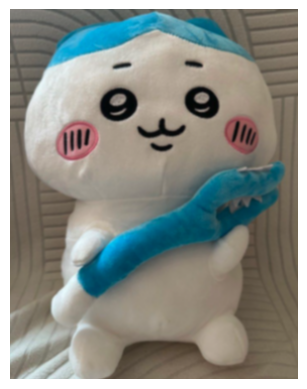

Image: /Users/chutszkan/Desktop/Github/ImageProcessing-note/CNNs/test_images/test1.jpg
Class probabilities:
  chikawa: 0.0000
  hachiwai: 1.0000
  usagi: 0.0000
Predicted class: hachiwai


In [14]:
predict_result('/Users/chutszkan/Desktop/Github/ImageProcessing-note/CNNs/test_images/test1.jpg')

/var/folders/8f/s_44b7ls3h596l8n0ck4wc3h0000gn/T/ipykernel_26614/200684378.py:44: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))

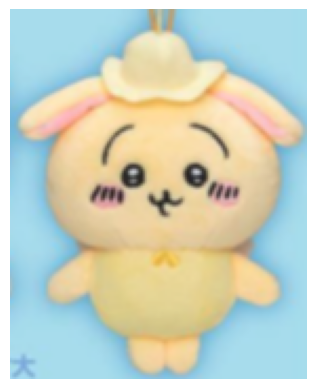

Image: /Users/chutszkan/Desktop/Github/ImageProcessing-note/CNNs/test_images/test3.jpg
Class probabilities:
  chikawa: 0.0000
  hachiwai: 0.0172
  usagi: 0.9828
Predicted class: usagi


In [15]:
predict_result('/Users/chutszkan/Desktop/Github/ImageProcessing-note/CNNs/test_images/test3.jpg')

/var/folders/8f/s_44b7ls3h596l8n0ck4wc3h0000gn/T/ipykernel_26614/200684378.py:44: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))

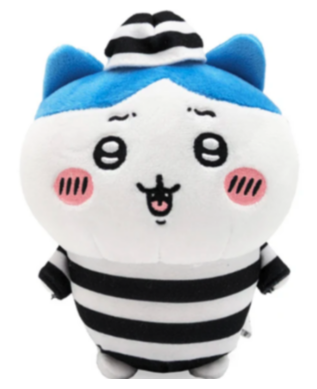

Image: /Users/chutszkan/Desktop/Github/ImageProcessing-note/CNNs/test_images/test4.jpg
Class probabilities:
  chikawa: 0.0000
  hachiwai: 1.0000
  usagi: 0.0000
Predicted class: hachiwai


In [16]:
predict_result('/Users/chutszkan/Desktop/Github/ImageProcessing-note/CNNs/test_images/test4.jpg')

/var/folders/8f/s_44b7ls3h596l8n0ck4wc3h0000gn/T/ipykernel_26614/200684378.py:44: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))

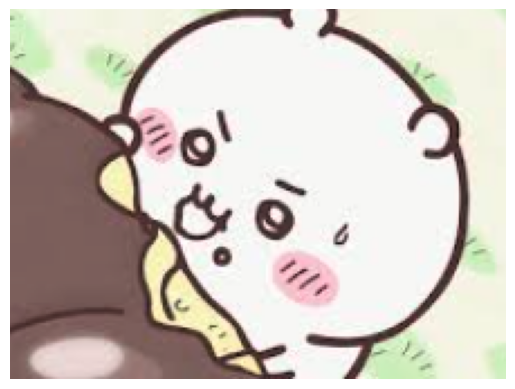

Image: /Users/chutszkan/Desktop/Github/ImageProcessing-note/CNNs/test_images/test2.jpg
Class probabilities:
  chikawa: 0.9808
  hachiwai: 0.0047
  usagi: 0.0145
Predicted class: chikawa


In [17]:
predict_result('/Users/chutszkan/Desktop/Github/ImageProcessing-note/CNNs/test_images/test2.jpg')